# Predictive Policing

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan, when, count, col, sequence, date_format, UserDefinedFunction
from datetime import datetime
import pandas as pd
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType
import numpy as np
import seaborn as sns
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pymongo import MongoClient
from fbprophet import Prophet
from pyspark.sql.functions import current_date
import re
import json
from pyspark.ml.feature import StringIndexer
%matplotlib inline
plt.style.use('seaborn')

Importing plotly failed. Interactive plots will not work.


In [2]:
conn = MongoClient("mongo", 27017)
db = conn.mydb
collection_crime = db.chicago_crime
collection_crime_clean = db.chicago_crime_cleaned
collection_primary_type = db.primary_type
collection_location_description = db.location_description
collection_description = db.description

## Initalize Spark Session

In [3]:
spark = SparkSession.\
        builder.\
        appName("pysparkapp_prediction").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "2g").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()

## Get the cleaned data

In [4]:
#read from mongo
df_cleaned = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.chicago_crime_cleaned").load()

In [12]:
df_primary_type = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.primary_type").load()

In [5]:
df_cleaned.show(5)

+--------------------+------+--------------------+-----------+--------------+-------------------+-------------------+---------------+--------+--------+------------+------------------------+-------------+----------------+--------------------+----+----+
|                 _id|arrest|               block|case_number|community_area|               date|          date_time|description_int|district|domestic|    latitude|location_description_int|    longitude|primary_type_int|          updated_on|ward|year|
+--------------------+------+--------------------+-----------+--------------+-------------------+-------------------+---------------+--------+--------+------------+------------------------+-------------+----------------+--------------------+----+----+
|[600941abb8311119...| false|   018XX N TALMAN AV|    G055473|          null|2001-01-01 00:00:00|2001-01-01 00:00:00|              1|     014|   false|41.914955409|                     180|-87.693605188|              34|2015-08-17T15:03:...|nul

In [6]:
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+---+------+-----+-----------+--------------+----+---------+---------------+--------+--------+--------+------------------------+---------+----------------+----------+------+----+
|_id|arrest|block|case_number|community_area|date|date_time|description_int|district|domestic|latitude|location_description_int|longitude|primary_type_int|updated_on|  ward|year|
+---+------+-----+-----------+--------------+----+---------+---------------+--------+--------+--------+------------------------+---------+----------------+----------+------+----+
|  0|     0|    0|          3|        604201|   0|        0|              0|      49|       0|       0|                       0|        0|               0|         0|605506|   0|
+---+------+-----+-----------+--------------+----+---------+---------------+--------+--------+--------+------------------------+---------+----------------+----------+------+----+



In [7]:
df_cleaned.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- block: string (nullable = true)
 |-- case_number: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- description_int: string (nullable = true)
 |-- district: string (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- latitude: string (nullable = true)
 |-- location_description_int: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- primary_type_int: string (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- year: string (nullable = true)



# Multilayer Perceptron
## Predict Crime based on Time, weekday and District 

In [5]:
df_cleaned.createOrReplaceTempView("view_for_prediction")

In [9]:
df_cleaned.columns

['_id',
 'arrest',
 'block',
 'case_number',
 'community_area',
 'date',
 'date_time',
 'description_int',
 'district',
 'domestic',
 'latitude',
 'location_description_int',
 'longitude',
 'primary_type_int',
 'updated_on',
 'ward',
 'year']

In [6]:
#df_for_prediction = spark.sql('Select community_area, district, weekday(date) as weekday, primary_type_int FROM view_for_prediction')
df_for_prediction = spark.sql('Select district, date_time, primary_type_int, weekday(date) as weekday FROM view_for_prediction')

In [7]:
df_for_prediction_primary_count = spark.sql('Select primary_type_int, count(primary_type_int) as count FROM view_for_prediction GROUP BY primary_type_int')

In [8]:
count_primary = [item[0] for item in df_for_prediction_primary_count.select("count").collect()]
primary_type_int = [item[0] for item in df_for_prediction_primary_count.select("primary_type_int").collect()]
number_of_crimes_primary = {"count_primary":count_primary, "primary_type_int" : primary_type_int}
pd_primary_count = pd.DataFrame(number_of_crimes_primary, columns=number_of_crimes_primary.keys())

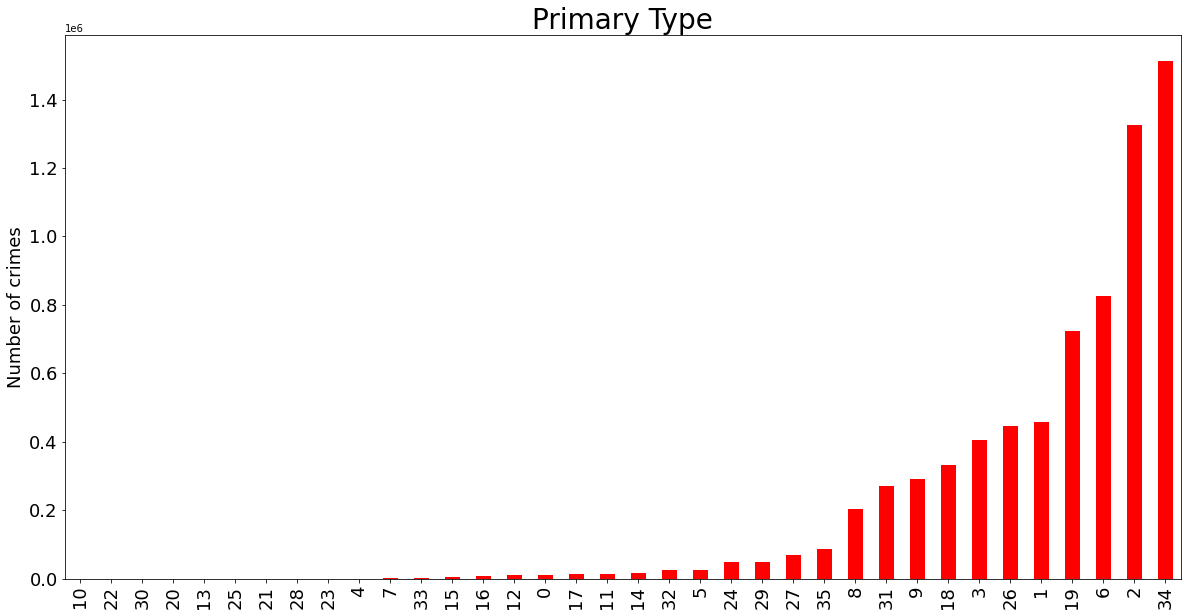

In [9]:
pd_primary_count = pd_primary_count.sort_values(by = "count_primary")
pd_primary_count.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "primary_type_int", y = "count_primary", legend = False)
plt.xlabel("", fontsize = 18)
plt.ylabel("Number of crimes", fontsize = 18)
plt.title("Primary Type", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

THEFT,ROBBERY, NARCOTICS, ASSAULT, BURGLARY, BATTERY, MOTOR VEHICLE THEFT, OFFENSE INVOLVING CHILDREN, CRIMINAL TRESPASS, WEAPONS VIOLATION, PUBLIC PEACE VIOLATION  , PROSTITUTION,DECEPTIVE PRACTICE 

In [10]:
primary_types = [34,31,19,1,3,2,18,24,8,35,29,27,9]

In [7]:
df_for_prediction = spark.sql("""Select district, date_time, primary_type_int, weekday(date) as weekday
                                FROM view_for_prediction
                                where primary_type_int IN (34,31,19,1,3,2,18,24,8,35,29,27,9)  """)        

In [8]:
df_unique_primary = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.primary_type").load()

In [9]:
unique_primary = df_unique_primary.select(df_unique_primary.primary_type, df_unique_primary.id).collect()

In [10]:
unique_primary.sort()

In [11]:
myfunc =  UserDefinedFunction(lambda x: unique_primary[int(x)].primary_type)                            
df = df_for_prediction.withColumn('primary_type', myfunc(col('primary_type_int')))

In [12]:
primary_types = df.select(df.primary_type).distinct().collect()

In [13]:
indexer = StringIndexer(inputCol="primary_type", outputCol="primary_type_int_new")
df_for_prediction = indexer.fit(df).transform(df)

In [14]:
df_for_prediction.createOrReplaceTempView("view_for_prediction_cleaned")

In [17]:
df_for_prediction_plot = spark.sql('Select primary_type, primary_type_int_new, count(primary_type_int_new) as count FROM view_for_prediction_cleaned GROUP BY primary_type,primary_type_int_new')

In [26]:
count = [item[0] for item in df_for_prediction_plot.select("count").collect()]
primary_type_int_new = [item[0] for item in df_for_prediction_plot.select("primary_type_int_new").collect()]
number_of_crimes_primary_plot = {"count_primary":count, "primary_type_int_new" : primary_type_int_new}
pd_primary_count_plot = pd.DataFrame(number_of_crimes_primary_plot, columns=number_of_crimes_primary_plot.keys())

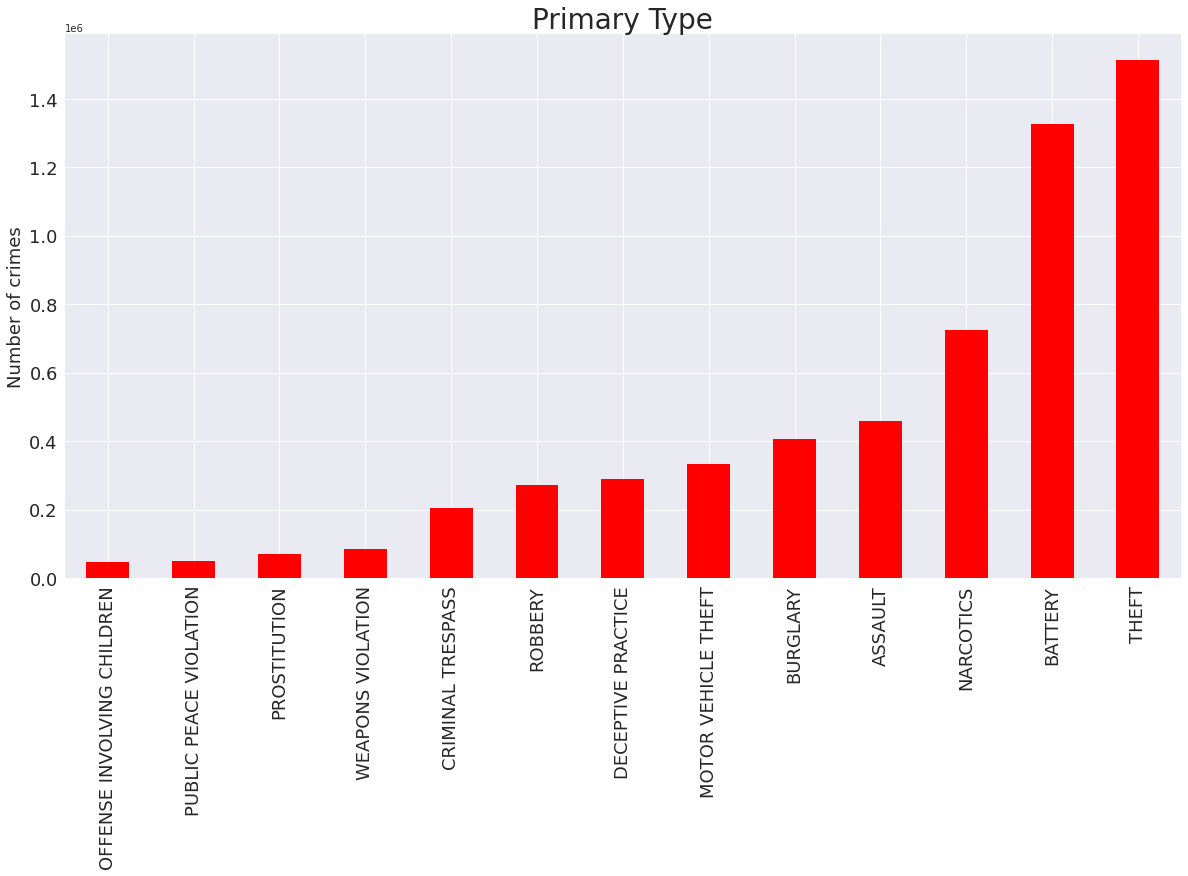

In [25]:
pd_primary_count_plot = pd_primary_count_plot.sort_values(by = "count_primary")
pd_primary_count_plot.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "primary_type", y = "count_primary", legend = False)
plt.xlabel("", fontsize = 18)
plt.ylabel("Number of crimes", fontsize = 18)
plt.title("Primary Type", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [15]:
num_samples = df_for_prediction.count()

In [23]:
num_samples

5778813

In [29]:
fractions = {}
for i in pd_primary_count_plot.iterrows():  
    index = i[1].primary_type_int_new
    count = i[1].count_primary
    print(index, 'primary')
    print(count,'count')

    if count > 700000:
        fractions[index] = 0.4 - (count / num_samples)
        print(0.4 - (count / num_samples),  'fraction1')
    elif count > 300000:
        fractions[index] = 0.8 - (count / num_samples)
        print(0.8  - (count / num_samples),  'fraction2')
    elif count > 200000:
        fractions[index] = 0.9  - (count / num_samples)
        print(0.9  - (count / num_samples),  'fraction3')
    elif count > 100000:
        fractions[index] = 1 - (count / num_samples)
        print(1  - (count / num_samples),  'fraction4')
    else:
        fractions[index] = 1
    

   
#    print(1 - (count / num_samples))



1.0 primary
1325902.0 count
0.1705580713547921 fraction1
7.0 primary
271544.0 count
0.8530104192677631 fraction3
12.0 primary
47883.0 count
8.0 primary
203903.0 count
0.8647154182009351 fraction3
5.0 primary
332646.0 count
0.7424369675917875 fraction2
9.0 primary
86249.0 count
3.0 primary
457823.0 count
0.7207755987258976 fraction2
4.0 primary
405391.0 count
0.7298487422936164 fraction2
10.0 primary
69156.0 count
0.0 primary
1512398.0 count
0.13828569984874056 fraction1
2.0 primary
725312.0 count
0.274487719190775 fraction1
11.0 primary
50368.0 count
6.0 primary
290238.0 count
0.8497754988784029 fraction3


In [30]:
df_for_prediction = df_for_prediction.na.drop(subset=['district', 'date_time', 'primary_type_int'])
df_for_prediction = df_for_prediction.withColumn('time', date_format("date_time","HH:mm:ss"))
myfunc =  UserDefinedFunction(lambda x: x.replace(':',''))
df_for_prediction = df_for_prediction.withColumn('time_int', myfunc(col('time')))
df_for_prediction = df_for_prediction.withColumn("district", df_for_prediction["district"].cast(IntegerType()))
df_for_prediction = df_for_prediction.withColumn("primary_type_int", df_for_prediction["primary_type_int"].cast(IntegerType()))
df_for_prediction = df_for_prediction.withColumn("time_int", df_for_prediction["time_int"].cast(IntegerType()))
df_for_prediction = df_for_prediction.withColumn("weekday", df_for_prediction["weekday"].cast(IntegerType()))

In [31]:
sampled_df = df_for_prediction.stat.sampleBy("primary_type_int_new", fractions,num_samples )

In [27]:
sampled_df.count()

2415756

In [ ]:
sampled_df.createOrReplaceTempView("stratified_sample")

In [29]:
df_for_prediction_strat = spark.sql('Select primary_type_int_new, count(primary_type_int_new) as count FROM stratified_sample GROUP BY primary_type_int_new')

In [30]:
count = [item[0] for item in df_for_prediction_strat.select("count").collect()]
primary_type_int_new = [item[0] for item in df_for_prediction_strat.select("primary_type_int_new").collect()]
number_of_crimes_primary_strat = {"count":count, "primary_type_int_new" : primary_type_int_new}
pd_primary_count_strat = pd.DataFrame(number_of_crimes_primary_strat, columns=number_of_crimes_primary_strat.keys())


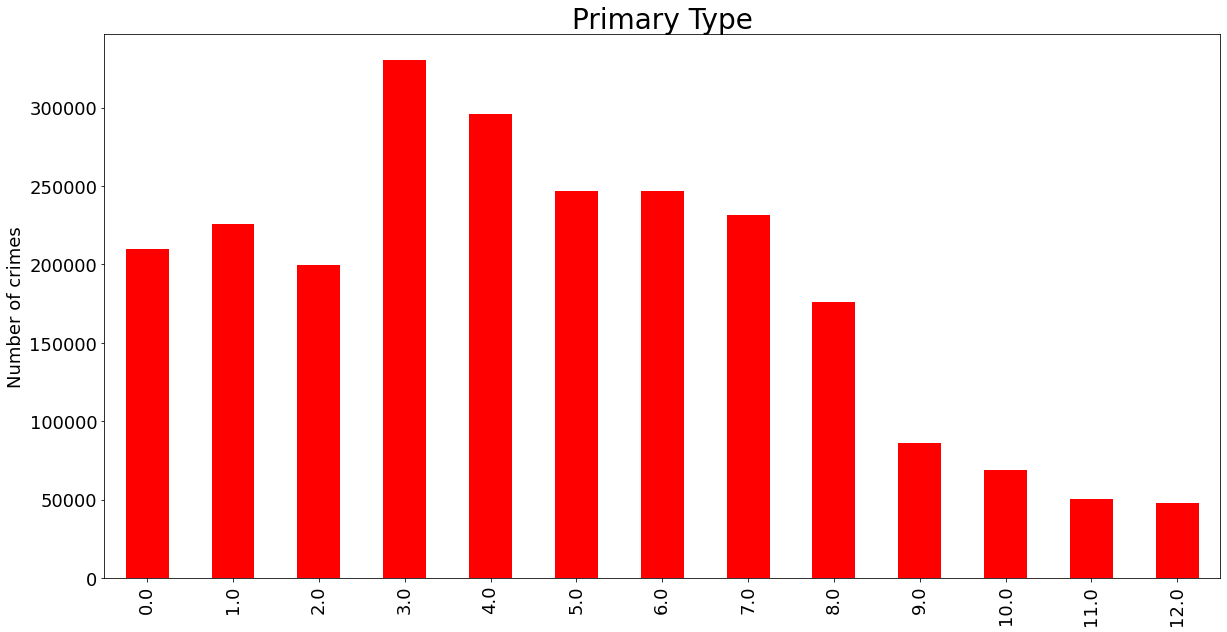

In [31]:
pd_primary_count_strat = pd_primary_count_strat.sort_values(by = "count")
pd_primary_count_strat.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "primary_type_int_new", y = "count", legend = False)
plt.xlabel("", fontsize = 18)
plt.ylabel("Number of crimes", fontsize = 18)
plt.title("Primary Type", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [32]:
#feature_columns = df_for_prediction.columns[:-1]
feature_columns = ['district', 'time_int', 'weekday']
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
data = assembler.transform(df_for_prediction)
train = assembler.transform(sampled_df)

In [33]:
data = data.drop('district', 'weekday', 'time_int', 'time', 'date_time')
train = train.drop('district', 'weekday', 'time_int', 'time', 'date_time')
test = data.subtract(train)

In [40]:
output_dim = 13
input_dim = 3

layers_arr = [
    [input_dim,3,4,output_dim],
    [input_dim,3,5,output_dim],
    [input_dim,3,6,output_dim],
    [input_dim,3,7,output_dim],
    [input_dim,3, 5, 6 ,output_dim],
    [input_dim,4,4,output_dim],
    [input_dim,4,5,output_dim],
    [input_dim,4,6,output_dim],
    [input_dim,4,7,output_dim],
    [input_dim,4,8,output_dim],
    [input_dim,4, 5 , 8,output_dim],
    [input_dim,5,3,output_dim],
    [input_dim,5,4,output_dim],
    [input_dim,5,5,output_dim],
    [input_dim,5,6,output_dim],
    [input_dim,5,7,output_dim],
    [input_dim,5,8,output_dim],
    [input_dim,5, 6 , 7,output_dim],
    [input_dim,6, 6 ,output_dim],
    [input_dim,6, 8 ,output_dim],
    [input_dim,8,16,output_dim]

]

In [42]:
models = []
results = []

for layers in layers_arr:
    print(layers)
    
    trainer_default = MultilayerPerceptronClassifier(maxIter=75,
                                                     layers=layers,
                                                     blockSize=128,
                                                     seed=1234,
                                                     labelCol="primary_type_int_new",
                                                     featuresCol="features")
    
    trainer_sgd = MultilayerPerceptronClassifier(maxIter=75,
                                                 layers=layers,
                                                 blockSize=128,
                                                 seed=1234,
                                                 labelCol="primary_type_int_new",
                                                 featuresCol="features",
                                                 solver='gd')
    model_default = trainer_default.fit(train)
    print("model default trained")

    model_sgd = trainer_sgd.fit(train)
    
    print("model sgd trained")

    models.append(model_default)
    models.append(model_sgd)
    
    result_default = model_default.transform(test)
    predictionAndLabels_default = result_default.select("prediction", "primary_type_int_new")
    evaluator_default = MulticlassClassificationEvaluator(labelCol="primary_type_int_new", predictionCol="prediction", metricName="accuracy")
    print("Test set accuracy default = " + str(evaluator_default.evaluate(predictionAndLabels_default)))

    result_sgd = model_sgd.transform(test)
    predictionAndLabels_sgd = result_sgd.select("prediction", "primary_type_int_new")
    evaluator_sgd = MulticlassClassificationEvaluator(labelCol="primary_type_int_new", predictionCol="prediction", metricName="accuracy")
    print("Test set accuracy SGD = " + str(evaluator_sgd.evaluate(predictionAndLabels_sgd)))
    
    results.append(result_default)
    results.append(result_sgd)

[3, 3, 4, 13]
model default trained
model svg trained
Test set accuracy default = 0.04102333768045891
Test set accuracy SGD = 0.02610185946975826
[3, 3, 5, 13]
model default trained
model svg trained
Test set accuracy default = 0.04082670833666009
Test set accuracy SGD = 0.014229189553864879
[3, 3, 6, 13]
model default trained
model svg trained
Test set accuracy default = 0.04073446932836212
Test set accuracy SGD = 0.04044434709997125
[3, 3, 7, 13]
model default trained
model svg trained
Test set accuracy default = 0.040918891568242216
Test set accuracy SGD = 0.02570472983455161
[3, 3, 5, 6, 13]
model default trained
model svg trained
Test set accuracy default = 0.04050580951186417
Test set accuracy SGD = 0.0
[3, 4, 4, 13]
model default trained
model svg trained
Test set accuracy default = 0.04059513050146523
Test set accuracy SGD = 0.04107907722365554
[3, 4, 5, 13]
model default trained
model svg trained
Test set accuracy default = 0.0404554252533303
Test set accuracy SGD = 0.02609809

In [43]:
layers_2 = [
[3, 5, 6 , 7, 13],
[3, 8, 16, 13],
[3, 4, 7, 13],
[3, 8, 16, 24, 13]]

In [46]:
models2 = []
results2 = []

for layers in layers_2:
    print(layers)
    
    trainer_sgd = MultilayerPerceptronClassifier(maxIter=200,
                                                 layers=layers,
                                                 blockSize=128,
                                                 seed=1234,
                                                 labelCol="primary_type_int_new",
                                                 featuresCol="features",
                                                 solver='gd',
                                                 stepSize=0.01)


    model_sgd = trainer_sgd.fit(train)    
    print("model sgd trained")

    models2.append(model_sgd)

    result_sgd = model_sgd.transform(test)
    predictionAndLabels_sgd = result_sgd.select("prediction", "primary_type_int_new")
    evaluator_sgd = MulticlassClassificationEvaluator(labelCol="primary_type_int_new", predictionCol="prediction", metricName="accuracy")
    print("Test set accuracy SGD = " + str(evaluator_sgd.evaluate(predictionAndLabels_sgd)))    

    results2.append(result_sgd)

[3, 5, 6, 7, 13]
model svg trained
Test set accuracy SGD = 0.3824118758705271
[3, 8, 16, 13]
model svg trained
Test set accuracy SGD = 0.3824510445426834
[3, 4, 7, 13]
model svg trained
Test set accuracy SGD = 0.3813278965116518
[3, 8, 16, 24, 13]
model svg trained
Test set accuracy SGD = 0.025527348778081792


In [47]:
layer = [3, 8, 16, 13]

trainer_sgd = MultilayerPerceptronClassifier(maxIter=500,
                                             layers=layers,
                                             blockSize=256,
                                             seed=1234,
                                             labelCol="primary_type_int_new",
                                             featuresCol="features",
                                             solver='gd')


model_sgd = trainer_sgd.fit(train)    
print("model sgd trained")  

result_sgd = model_sgd.transform(test)
predictionAndLabels_sgd = result_sgd.select("prediction", "primary_type_int_new")
evaluator_sgd = MulticlassClassificationEvaluator(labelCol="primary_type_int_new", predictionCol="prediction", metricName="accuracy")
print("Test set accuracy SGD = " + str(evaluator_sgd.evaluate(predictionAndLabels_sgd)))   

model svg trained
Test set accuracy SGD = 0.04083068620418759


In [38]:
print("Test set accuracy default = " + str(evaluator_default.evaluate(predictionAndLabels_default)))


Test set accuracy default = 0.04055682611851385


In [37]:
today_weekday = 6
time_now = 135400
district = 8.0
vector = [district, time_now, today_weekday]
df = spark.createDataFrame([(vector)],("district", "time_int", "weekday"))

feature_columns = ['district', 'time_int', 'weekday']
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
#result = model.evaluate(test)
data = assembler.transform(df)
data.show(20)
data = data.drop('district')
data = data.drop('time_int')
data = data.drop('weekday')
result = model_sgd.transform(data)
result.show()
pred = result.select('prediction').collect()

+--------+--------+-------+------------------+
|district|time_int|weekday|          features|
+--------+--------+-------+------------------+
|     8.0|       6| 135400|[8.0,6.0,135400.0]|
+--------+--------+-------+------------------+

+------------------+--------------------+--------------------+----------+
|          features|       rawPrediction|         probability|prediction|
+------------------+--------------------+--------------------+----------+
|[8.0,6.0,135400.0]|[1.45901177345471...|[0.12978330310180...|       7.0|
+------------------+--------------------+--------------------+----------+



# Time series forecasting
Predict the crime rate in the next months

In [ ]:
#create view
df_cleaned.createOrReplaceTempView("view_for_forecasting")

In [ ]:
df_cleaned.show(5)

In [ ]:
#select the number of crimes per year
df_for_forecasting = spark.sql('Select date, COUNT(date) as num_crimes FROM view_for_forecasting GROUP BY date')
#df_for_forecasting = spark.sql('Select date_time, primary_type_int FROM view_for_forecasting')


In [ ]:
#filter for all crimes in 2018, 2019, 2020,2021
begin_date = '2018-01-01'
begin_date = datetime.strptime(begin_date, '%Y-%m-%d')

end_date = '2020-12-31'
end_date = datetime.strptime(end_date, '%Y-%m-%d')

df_for_forecasting = df_for_forecasting.where(col('date').between(limit, end_date))


In [ ]:
df_for_forecasting = df_for_forecasting.sort("date")

In [ ]:
df_for_forecasting.show(5)

In [ ]:
#convert to pandas dataframe
pd_df_for_forecasting = df_for_forecasting.toPandas()


In [ ]:
#rename the columns
pd_df_for_forecasting = pd_df_for_forecasting.rename(columns = {'date': 'ds', 'num_crimes': 'y'})

In [ ]:
#create a model and fit the data
m = Prophet(interval_width = 0.95, daily_seasonality = False)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 10)
m.add_seasonality(name = 'quarterly', period = 91.5, fourier_order = 10)
m.fit(pd_df_for_forecasting)

In [ ]:
#predict the future of crime rates
future = m.make_future_dataframe(periods = 24, freq = 'M')
pred = m.predict(future)

In [ ]:
#show prediction
pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
#plot the result
fig = m.plot(pred, xlabel ='Date', ylabel = 'Crime Rate')

# Predict when the next bulgary in ward 2 takes place 

In [ ]:
#create view
df_cleaned.createOrReplaceTempView("view_for_forecasting_primary_type")


In [ ]:
#select the number of crimes per district and primary type
df_for_forecasting_primary_type = spark.sql('Select date, ward, primary_type_int, COUNT(date) as num_crimes FROM view_for_forecasting_primary_type GROUP BY date, ward, primary_type_int')


In [ ]:
#get the primary_types from mongo
df_primary_type = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.primary_type").load()


In [ ]:
df_primary_type.show(30)

In [ ]:
#get int code from bulgary
primary_type_int = df_primary_type.filter(df_primary_type.primary_type == 'BURGLARY').select('id').head()[0]

In [ ]:
#filter for all bulgarys in ward 2
df_for_forecasting_primary_type = df_for_forecasting_primary_type.filter((df_for_forecasting_primary_type.ward  == "2") & (df_for_forecasting_primary_type.primary_type_int  == primary_type_int))


In [ ]:
#filter for all crimes in 2020 and 2021
limit = '2020-01-01'
limit = datetime.strptime(limit, '%Y-%m-%d')
df_for_forecasting_primary_type = df_for_forecasting_primary_type.where(col('date').between(limit, current_date()))

In [ ]:
#convert the date into DateType
myfunc =  UserDefinedFunction(lambda x: x.date(), DateType())
df_for_forecasting_primary_type = df_for_forecasting_primary_type.withColumn('date', myfunc(col('date')))

In [ ]:
df_for_forecasting_primary_type.show(5)

In [ ]:
#drop columne ward and primary_type int
df_for_forecasting_primary_type = df_for_forecasting_primary_type.drop('ward','primary_type_int')

In [ ]:
#count the dates where the crime take place
df_for_forecasting_primary_type.count()

In [ ]:
#convert into pandas dataframe
pd_df_for_forecasting_primary_type = df_for_forecasting_primary_type.toPandas()


In [ ]:
#convert date to datetime
pd_df_for_forecasting_primary_type['date']= pd.to_datetime(pd_df_for_forecasting_primary_type['date'])

In [ ]:
#get the date from today
today = pd.to_datetime('today').normalize()
today = datetime.strftime(today, '%Y-%m-%d')
today

In [ ]:
#series with all dates from 2020 till now
idx = pd.period_range(min(pd_df_for_forecasting_primary_type.date), today)

In [ ]:
#create dataframe with all dates
df_with_all_date = pd.DataFrame({'date':idx})


In [ ]:
#convert the date to datetime format
df_with_all_date['date'] = df_with_all_date['date'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
df_with_all_date['date']= pd.to_datetime(df_with_all_date['date'])

In [ ]:
#join the dataframes, so that we have a new dataframe with all dates and the number of crimes per day
df_with_all_date =df_with_all_date.set_index('date').join(pd_df_for_forecasting_primary_type.set_index('date'))

In [ ]:
df_with_all_date.tail(30)

In [ ]:
# fill all NaNs (no crime take place) with 0
df_with_all_date = df_with_all_date.fillna(0)

In [ ]:
#reset the index from dataframe
df_with_all_date.reset_index(level=0, inplace=True)

In [ ]:
#rename the columns
df_with_all_date = df_with_all_date.rename(columns = {'date': 'ds', 'num_crimes': 'y'})

In [ ]:
#create a model and fit it
m = Prophet(interval_width = 0.95, daily_seasonality = True)
m.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 10)
m.add_seasonality(name = 'quarterly', period = 91.5, fourier_order = 10)
m.fit(df_with_all_date)

In [ ]:
#predict the futer
future = m.make_future_dataframe(periods = 100, freq = 'd')
pred = m.predict(future)

In [ ]:
pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
#round the float to int -> it can only one crime take place but no 0,5 crimes
pred['yhat'] = pred['yhat'].round(0).astype(int)

In [ ]:
#found the day on which the next bulgary starts in ward 2
i = 0
for index, row in pred.iterrows():
    prediction = row['yhat']
    date = str(row['ds'])
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    today = date.today()
    if date > today and prediction >= 1:
        print('Next Bulgary in Ward 2 is on day: ' + str(date.day)+ '.'+ str(date.month)+ '.'+ str(date.year))
        i += 1
        if i == 10:
            break
    

In [ ]:
#plot the prediction
for index, row in pred.iterrows():
    prediction = row['yhat']
    if prediction <= 0:
        pred.loc[index, 'yhat'] = 0
fig = m.plot(pred, xlabel ='Date', ylabel = 'Crime Rate')

In [2]:
spark.stop()

NameError: name 'spark' is not defined